In [4]:
import pandas as pd
# from tqdm import tqdm
import numpy as np
import cv2
import os
import shutil
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms, utils
#from torchvision.transforms import v2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import torchsummary
from PIL import Image
from pathlib import Path
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
import torchsummary



# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
#from torchvision.transforms import v2

import cv2
import os
from glob import glob
#from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
import seaborn as sns

In [6]:
from tensorflow.keras.models import Sequential
import glob
import tensorflow
import cv2
#from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras import layers, models, optimizers

## Google Colab import (disregard if using other platform)

In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [8]:
!pwd

/content/drive/My Drive/Colab Notebooks


# Preprocessing


In [9]:
df = pd.read_csv('Chest_xray_Corona_Metadata.csv')
df.head()

#discard stress-smoking pneumonia images
df = df[df.Label_1_Virus_category != "Stress-Smoking"]

#create target variables
targets = [
    (df['Label'] == "Normal"),
    (df['Label'] == "Pnemonia") & (df['Label_1_Virus_category'] == "Virus"),
    (df['Label'] == "Pnemonia") & (df['Label_1_Virus_category'] == "bacteria")
]

values = ['Normal', 'Pnemonia-virus', 'Pnemonia-bacteria']
default = 'NaN'
df['target'] = np.select(targets, values, default=default)

chest_df = pd.DataFrame(df)
chest_df.shape

#check counts of target variables
target_counts = chest_df['target'].value_counts()
print(target_counts)

#split the dataframe
train = chest_df[chest_df['Dataset_type'] == 'TRAIN']
test = chest_df[chest_df['Dataset_type'] == 'TEST']

y_train = train['target']
y_test = test['target']


#augment data
batch_size = 32

train['target'] = train['target'].astype(str)
test['target'] = test['target'].astype(str)


# ✅ Split the DataFrame

test_df = test
train_df, val_df= train_test_split(
    train,
    test_size=0.2,
    stratify=train['target'],
    random_state=42

)

# ✅ Create data generators
train_gen = ImageDataGenerator(
    rescale=1/255,
    zoom_range=0.1,
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

val_gen = ImageDataGenerator(
    rescale=1/255,
    samplewise_center=True,
    samplewise_std_normalization=True
)


# Get the directory -----------
current_dir = os.getcwd()
train_dir = os.path.join(current_dir, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'train')

train_flow = train_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="X_ray_image_name",
    y_col='target',
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    target_size=(320, 320)
)

val_dir = os.path.join(current_dir, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'train')

val_flow = val_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=val_dir,
    x_col="X_ray_image_name",
    y_col='target',
    batch_size=32,
    shuffle=False,
    class_mode='categorical',
    target_size=(320, 320)
)

test_dir = os.path.join(current_dir, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'test')

test_flow = val_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="X_ray_image_name",
    y_col='target',
    batch_size=32,
    shuffle=False,
    class_mode='categorical',
    target_size=(320, 320)
)

target
Pnemonia-bacteria    2777
Normal               1576
Pnemonia-virus       1555
Name: count, dtype: int64


<ipython-input-9-789657b22eda>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'] = train['target'].astype(str)
<ipython-input-9-789657b22eda>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['target'] = test['target'].astype(str)


Found 4227 validated image filenames belonging to 3 classes.
Found 1057 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


In [10]:
early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)
epochs = 20

# Base DenseNet169 model

In [10]:
base_model5 = DenseNet169(weights='imagenet', include_top=False, input_shape=(320, 320, 3))
base_model5.trainable = False

model5 = models.Sequential([
    base_model5,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model5.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model5.fit(train_flow, epochs=epochs, validation_data=test_flow,callbacks=[early_stopping_callbacks])

test_loss, test_acc = model5.evaluate(test_flow)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

NameError: name 'DenseNet169' is not defined

# DenseNet Tuning 1
- Changed architecture
- Implemented batch normalization
- Adjusted all dropout layers to 0.2

In [1]:
base_model5 = DenseNet169(weights='imagenet', include_top=False, input_shape=(320, 320, 3))
base_model5.trainable = False

model5 = models.Sequential([
    base_model5,

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(256, activation ='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(128, activation ='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(3, activation ='softmax')

])

model5.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model5.fit(train_flow, epochs=epochs, validation_data=test_flow,callbacks=[early_stopping_callbacks])

test_loss, test_acc = model5.evaluate(test_flow)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

NameError: name 'train_flow' is not defined

# DenseNet169 Tuning 2
- Added convolutional and pooling layers

In [12]:
base_model5 = DenseNet169(weights='imagenet', include_top=False, input_shape=(320, 320, 3))
base_model5.trainable = False

model5 = models.Sequential([
    base_model5,

    layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same", input_shape=(320, 320, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation ='relu'),
    layers.Dense(128, activation ='relu'),
    layers.Dense(3, activation ='softmax')

])

model5.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model5.fit(train_flow, epochs=epochs, validation_data=test_flow,callbacks=[early_stopping_callbacks])

test_loss, test_acc = model5.evaluate(test_flow)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0983603..2.276356].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0734732..1.7913742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7132373..2.4910843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0393503..2.3440967].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1529925..2.6941895].


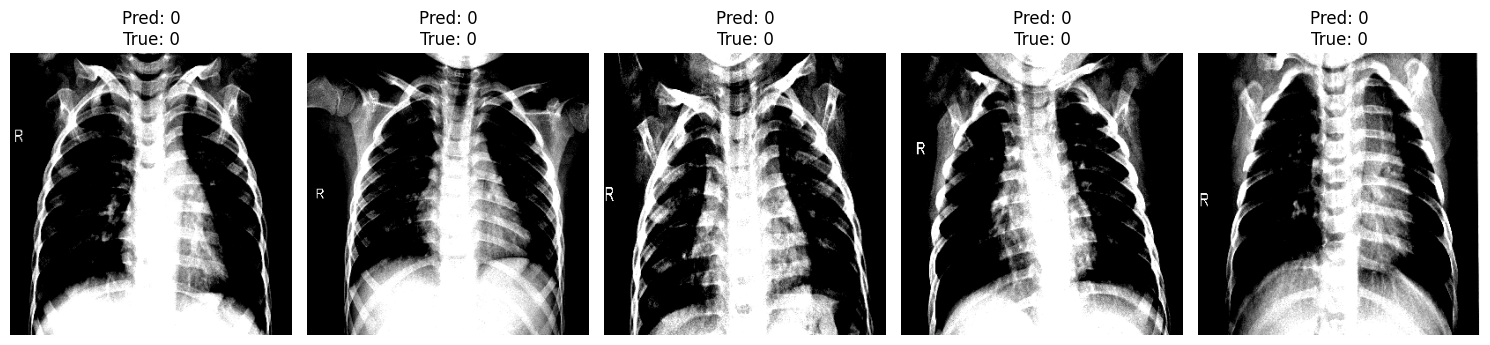

In [ ]:
import numpy as np
import random
# Get one batch of images and labels from test_flow
images, labels = next(test_flow)

# Get predictions from the model
predictions = model5.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Get class names from the generator
class_labels = list(test_flow.class_indices.keys())

# Pick 5 random indices
random_indices = random.sample(range(len(images)), 5)

# Plot the images and predictions
plt.figure(figsize=(15, 7))

for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[idx])
    plt.axis('off')
    plt.title(f"Pred: {class_labels[predicted_classes[idx]]}\nTrue: {class_labels[true_classes[idx]]}")

plt.tight_layout()
plt.show()